In [5]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Paths to data files
data_dir = "/glade/derecho/scratch/renatob/vic_alaska/output/"
file_hist = data_dir + "cmip5_ensemble_eb_rcp45.nc"  # Historical dataset

# Load dataset for the historical period (1980-2010)
ds_hist = xr.open_dataset(file_hist).sel(time=slice("1980-01-01", "2010-12-31")).mean(dim="time")

# Define soil depths (meters)
depths = {
    "Surface (0.02042 m)": "SOIL_TEMP1",
    "Mid-depth (0.97047 m)": "SOIL_TEMP2",
    "Deep (2.0 m)": "SOIL_TEMP3",
}

# Define station locations
stations = [
    {"name": "Tok", "lon": -142.8089, "lat": 63.3286},
    {"name": "Canol Trail", "lon": -130.98, "lat": 63.25},
]


In [6]:
# Function to extract data along the transect (with 25km buffer)
def select_nearby_points(ds, lon1, lat1, lon2, lat2, buffer_km=25):
    earth_radius_km = 6371.0
    buffer_deg = buffer_km / (earth_radius_km * np.pi / 180)

    lat_min, lat_max = min(lat1, lat2) - buffer_deg, max(lat1, lat2) + buffer_deg
    lon_min, lon_max = min(lon1, lon2) - buffer_deg, max(lon1, lon2) + buffer_deg

    ds_subset = ds.where(
        (ds.latitude >= lat_min) & (ds.latitude <= lat_max) &
        (ds.longitude >= lon_min) & (ds.longitude <= lon_max),
        drop=True
    )
    return ds_subset

# Extract relevant points
ds_selected = select_nearby_points(ds_hist, stations[0]["lon"], stations[0]["lat"],
                                   stations[1]["lon"], stations[1]["lat"])


In [7]:
# Extract latitudes and longitudes
lats = ds_selected.latitude.values.flatten()
lons = ds_selected.longitude.values.flatten()

# Remove NaNs
valid_points = ~np.isnan(lats) & ~np.isnan(lons)
lats, lons = lats[valid_points], lons[valid_points]

# Compute distance along transect
distances = np.linspace(0, 100 * np.sqrt((lats[-1] - lats[0])**2 + (lons[-1] - lons[0])**2), len(lats))


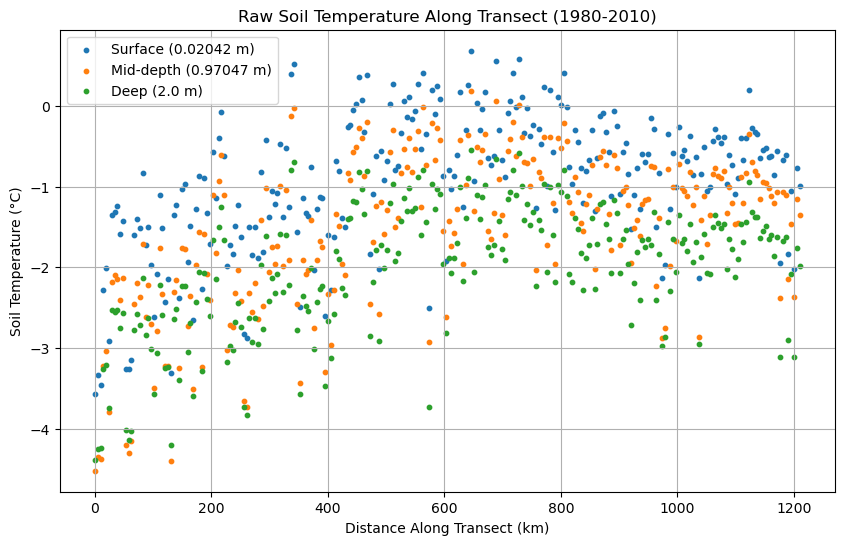

In [10]:
plt.figure(figsize=(10, 6))

# Plot temperature at each depth
for depth_label, depth_var in depths.items():
    #temp_values = ds_selected[depth_var].mean(dim=["y", "x"]).values.flatten()
    temp_values = ds_selected[depth_var].values.flatten()
    temp_values = temp_values[valid_points]  # Remove NaNs

    plt.scatter(distances, temp_values, label=depth_label, s=10)

plt.xlabel("Distance Along Transect (km)")
plt.ylabel("Soil Temperature (°C)")
plt.title("Raw Soil Temperature Along Transect (1980-2010)")
plt.legend()
plt.grid(True)

plt.show()


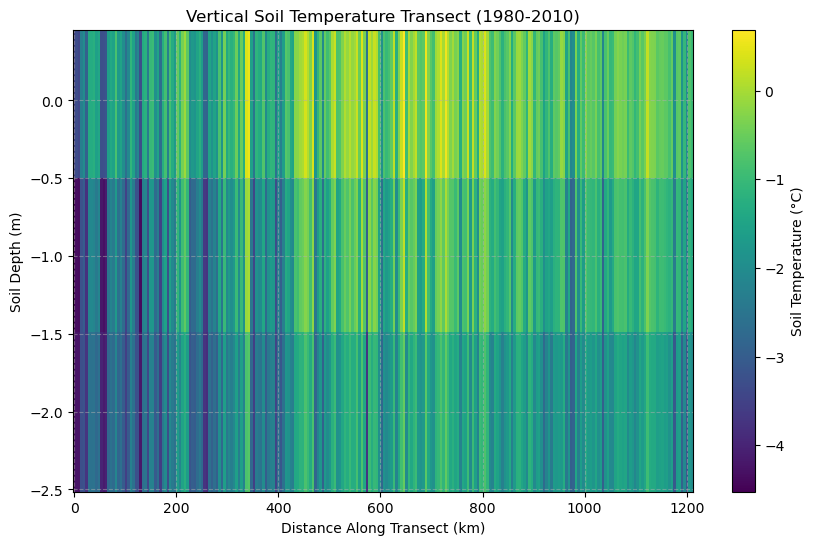

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Convert depth labels to numerical depth values
depth_values = np.array([0.02042, 0.97047, 2.0])  # Depth in meters

# Create a 2D array of temperatures (Distance x Depth)
temp_profile = np.array([ds_selected[depth_var].values.flatten()[valid_points] for depth_var in depths.values()])

# Ensure correct shape (Depth x Distance)
temp_profile = temp_profile.T  # Transpose to match (distance, depth)

# Create the figure
plt.figure(figsize=(10, 6))

# Plot the vertical temperature profile
contour = plt.pcolormesh(distances, -depth_values, temp_profile.T, cmap="viridis", shading="auto")

# Add colorbar
cbar = plt.colorbar(contour)
cbar.set_label("Soil Temperature (°C)")

# Labels and title
plt.xlabel("Distance Along Transect (km)")
plt.ylabel("Soil Depth (m)")
plt.title("Vertical Soil Temperature Transect (1980-2010)")

# Grid
plt.grid(True, linestyle="--", alpha=0.5)

# Show plot
plt.show()


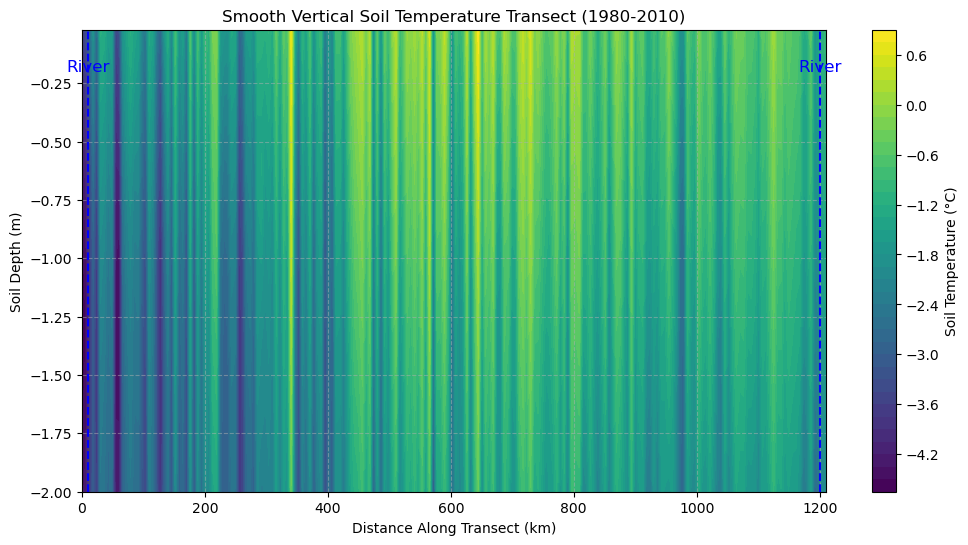

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Convert depth labels to numerical depth values
depth_values = np.array([0.02042, 0.97047, 2.0])  # Depth in meters

# Extract temperature data and reshape
temp_profile = np.array([ds_selected[depth_var].values.flatten()[valid_points] for depth_var in depths.values()])
temp_profile = temp_profile.T  # Ensure shape (distance, depth)

# Define high-resolution grid for interpolation
num_distance_points = 200  # Increase for smoother distance axis
num_depth_points = 100  # Increase for smoother depth resolution

grid_x = np.linspace(distances.min(), distances.max(), num_distance_points)
grid_y = np.linspace(depth_values.min(), depth_values.max(), num_depth_points)

# Interpolate data for smooth visualization
grid_xx, grid_yy = np.meshgrid(grid_x, grid_y)
grid_z = griddata(
    (np.repeat(distances, len(depth_values)), np.tile(depth_values, len(distances))),
    temp_profile.flatten(),
    (grid_xx, grid_yy),
    method='cubic'
)

# Plot the vertical transect of soil temperature
plt.figure(figsize=(12, 6))
contour = plt.contourf(grid_xx, -grid_yy, grid_z, cmap="viridis", levels=50)  # Negative depth for correct orientation

# Add colorbar
cbar = plt.colorbar(contour)
cbar.set_label("Soil Temperature (°C)")

# Indicate river locations on the top axis
river_positions = [distances[0] + 10, distances[-1] - 10]  # Approximate river locations
for pos in river_positions:
    plt.axvline(pos, color="blue", linestyle="dashed", linewidth=1.5)
    plt.text(pos, -0.2, "River", color="blue", fontsize=12, ha="center")

plt.xlabel("Distance Along Transect (km)")
plt.ylabel("Soil Depth (m)")
plt.title("Smooth Vertical Soil Temperature Transect (1980-2010)")
plt.grid(True, linestyle="--", alpha=0.5)

# Show plot
plt.show()


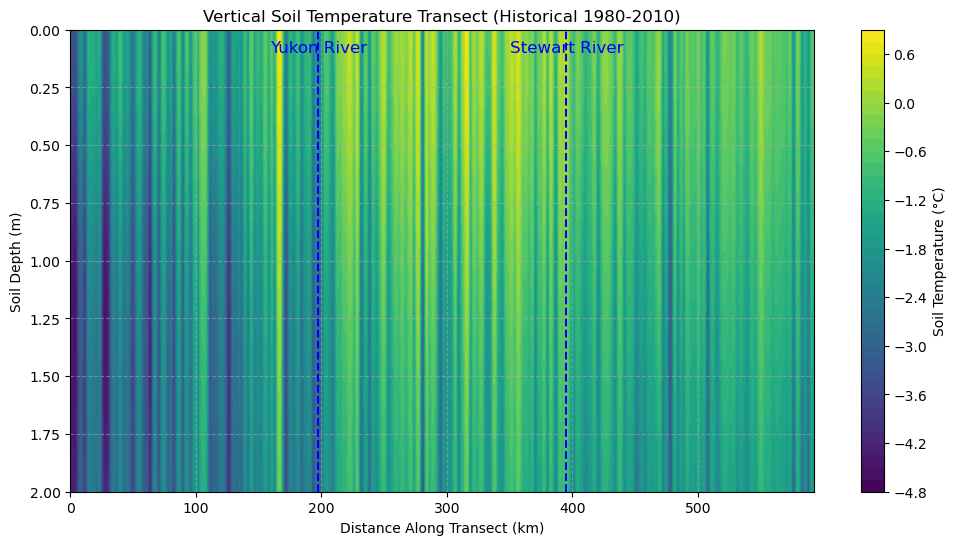

In [29]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from geopy.distance import geodesic

# ✅ Paths to data files
data_dir = "/glade/derecho/scratch/renatob/vic_alaska/output/"
file_hist = data_dir + "cmip5_ensemble_eb_rcp45.nc"  # Historical dataset

# ✅ Load dataset for the historical period (1980-2010)
ds_hist = xr.open_dataset(file_hist).sel(time=slice("1980-01-01", "2010-12-31")).mean(dim="time")

# ✅ Define soil depths (meters)
depths = {
    "Surface (0.02042 m)": "SOIL_TEMP1",
    "Mid-depth (0.97047 m)": "SOIL_TEMP2",
    "Deep (2.0 m)": "SOIL_TEMP3",
}

# ✅ Define station locations (Tok and Canol Trail)
stations = [
    {"name": "Tok", "lon": -142.8089, "lat": 63.3286},
    {"name": "Canol Trail", "lon": -130.98, "lat": 63.25},
]

# ✅ Function to extract data along the transect (with 25km buffer)
def select_nearby_points(ds, lon1, lat1, lon2, lat2, buffer_km=25):
    earth_radius_km = 6371.0
    buffer_deg = buffer_km / (earth_radius_km * np.pi / 180)

    lat_min, lat_max = min(lat1, lat2) - buffer_deg, max(lat1, lat2) + buffer_deg
    lon_min, lon_max = min(lon1, lon2) - buffer_deg, max(lon1, lon2) + buffer_deg

    ds_subset = ds.where(
        (ds.latitude >= lat_min) & (ds.latitude <= lat_max) &
        (ds.longitude >= lon_min) & (ds.longitude <= lon_max),
        drop=True
    )
    return ds_subset

# ✅ Extract relevant temperature data along the transect
ds_selected = select_nearby_points(ds_hist, stations[0]["lon"], stations[0]["lat"],
                                   stations[1]["lon"], stations[1]["lat"])

# ✅ Extract latitudes and longitudes
lats = ds_selected.latitude.values.flatten()
lons = ds_selected.longitude.values.flatten()

# ✅ Remove NaNs
valid_points = ~np.isnan(lats) & ~np.isnan(lons)
lats, lons = lats[valid_points], lons[valid_points]

# ✅ Compute the total distance along the transect (~700 km)
total_distance = geodesic((stations[0]["lat"], stations[0]["lon"]), (stations[1]["lat"], stations[1]["lon"])).km
distances = np.linspace(0, total_distance, len(lats))

# ✅ Extract historical temperature data for each depth level
temp_profile = np.array([ds_selected[depth_var].values.flatten()[valid_points] for depth_var in depths.values()])
temp_profile = np.vstack([temp_profile[0], temp_profile])  # Adds surface (0m) layer
temp_profile = temp_profile.T  # Shape (distance, depth)

# ✅ Convert depth labels to numerical depth values (positive values)
depth_values = np.array([0.0, 0.02042, 0.97047, 2.0])  # Depth in meters, with surface (0m)

# ✅ Define high-resolution grid for interpolation
num_distance_points = 600  # Increase for smooth distance axis
num_depth_points = 300  # Increase for smoother depth resolution

grid_x = np.linspace(0, total_distance, num_distance_points)
grid_y = np.linspace(depth_values.min(), depth_values.max(), num_depth_points)

# ✅ Interpolate temperature data for smooth visualization
grid_xx, grid_yy = np.meshgrid(grid_x, grid_y)
grid_z = griddata(
    (np.repeat(distances, len(depth_values)), np.tile(depth_values, len(distances))),
    temp_profile.flatten(),
    (grid_xx, grid_yy),
    method='cubic'
)

# ✅ Plot the vertical transect of soil temperature
plt.figure(figsize=(12, 6))
contour = plt.contourf(grid_xx, grid_yy, grid_z, cmap="viridis", levels=50)

# ✅ Reverse Y-axis so 0m is at the top
plt.gca().invert_yaxis()

# ✅ Add colorbar
cbar = plt.colorbar(contour)
cbar.set_label("Soil Temperature (°C)")

# ✅ **Place real Arctic rivers along the transect**
arctic_rivers = {
    "Yukon River": total_distance * (1/3),  # 1/3 of the transect
    "Stewart River": total_distance * (2/3)  # 2/3 of the transect
}
for river, pos in arctic_rivers.items():
    plt.axvline(pos, color="blue", linestyle="dashed", linewidth=1.5)
    plt.text(pos, 0.1, river, color="blue", fontsize=12, ha="center")

# ✅ Labels and Title
plt.xlabel("Distance Along Transect (km)")
plt.ylabel("Soil Depth (m)")
plt.title("Vertical Soil Temperature Transect (Historical 1980-2010)")
plt.grid(True, linestyle="--", alpha=0.5)

# ✅ Show the plot
plt.show()


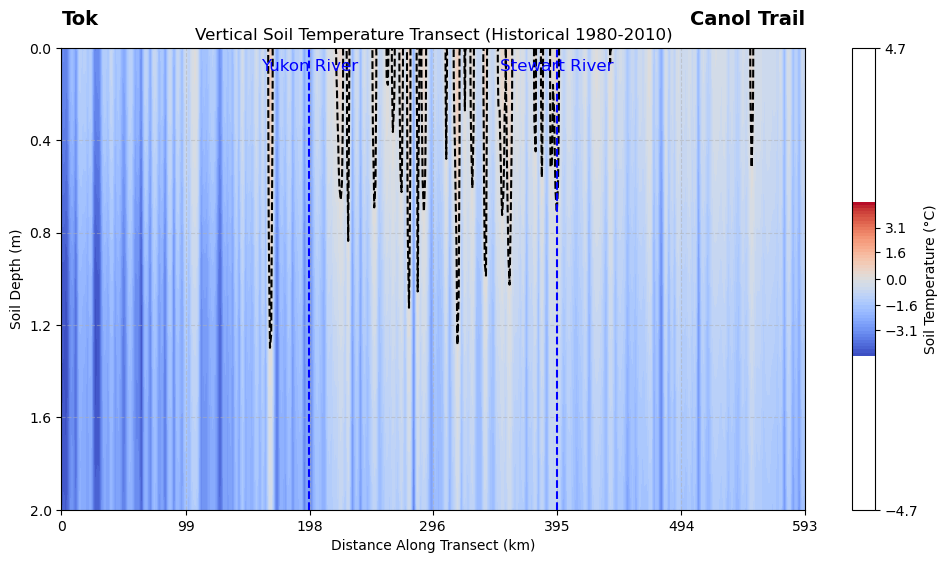

In [41]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from geopy.distance import geodesic

# ✅ Paths to data files
data_dir = "/glade/derecho/scratch/renatob/vic_alaska/output/"
file_hist = data_dir + "cmip5_ensemble_eb_rcp45.nc"  # Historical dataset

# ✅ Load dataset for the historical period (1980-2010)
ds_hist = xr.open_dataset(file_hist).sel(time=slice("1980-01-01", "2010-12-31")).mean(dim="time")

# ✅ Define soil depths (meters)
depths = {
    "Surface (0.02042 m)": "SOIL_TEMP1",
    "Mid-depth (0.97047 m)": "SOIL_TEMP2",
    "Deep (2.0 m)": "SOIL_TEMP3",
}

# ✅ Define station locations (Tok and Canol Trail)
stations = [
    {"name": "Tok", "lon": -142.8089, "lat": 63.3286},
    {"name": "Canol Trail", "lon": -130.98, "lat": 63.25},
]

# ✅ Function to extract data along the transect (with 25km buffer)
def select_nearby_points(ds, lon1, lat1, lon2, lat2, buffer_km=25):
    earth_radius_km = 6371.0
    buffer_deg = buffer_km / (earth_radius_km * np.pi / 180)

    lat_min, lat_max = min(lat1, lat2) - buffer_deg, max(lat1, lat2) + buffer_deg
    lon_min, lon_max = min(lon1, lon2) - buffer_deg, max(lon1, lon2) + buffer_deg

    ds_subset = ds.where(
        (ds.latitude >= lat_min) & (ds.latitude <= lat_max) &
        (ds.longitude >= lon_min) & (ds.longitude <= lon_max),
        drop=True
    )
    return ds_subset

# ✅ Extract relevant temperature data along the transect
ds_selected = select_nearby_points(ds_hist, stations[0]["lon"], stations[0]["lat"],
                                   stations[1]["lon"], stations[1]["lat"])

# ✅ Extract latitudes and longitudes
lats = ds_selected.latitude.values.flatten()
lons = ds_selected.longitude.values.flatten()

# ✅ Remove NaNs
valid_points = ~np.isnan(lats) & ~np.isnan(lons)
lats, lons = lats[valid_points], lons[valid_points]

# ✅ Compute the total distance along the transect (~700 km)
total_distance = geodesic((stations[0]["lat"], stations[0]["lon"]), (stations[1]["lat"], stations[1]["lon"])).km
distances = np.linspace(0, total_distance, len(lats))

# ✅ Extract historical temperature data for each depth level
temp_profile = np.array([ds_selected[depth_var].values.flatten()[valid_points] for depth_var in depths.values()])
temp_profile = np.vstack([temp_profile[0], temp_profile])  # Adds surface (0m) layer
temp_profile = temp_profile.T  # Shape (distance, depth)

# ✅ Convert depth labels to numerical depth values (positive values)
depth_values = np.array([0.0, 0.02042, 0.97047, 2.0])  # Depth in meters, with surface (0m)

# ✅ Define high-resolution grid for interpolation
num_distance_points = 600  # Increase for smooth distance axis
num_depth_points = 300  # Increase for smoother depth resolution

grid_x = np.linspace(0, total_distance, num_distance_points)
grid_y = np.linspace(depth_values.min(), depth_values.max(), num_depth_points)

# ✅ Interpolate temperature data for smooth visualization
grid_xx, grid_yy = np.meshgrid(grid_x, grid_y)
grid_z = griddata(
    (np.repeat(distances, len(depth_values)), np.tile(depth_values, len(distances))),
    temp_profile.flatten(),
    (grid_xx, grid_yy),
    method='cubic'
)

# ✅ Define **blue-to-red** colormap where 0°C is white
cmap = plt.get_cmap("coolwarm")  # "coolwarm" provides blue (cold) → white (0°C) → red (hot)
vmin, vmax = np.min(grid_z), np.max(grid_z)  # Dynamic color scaling

# ✅ Adjust colormap to ensure **0°C is centered**
abs_max = max(abs(vmin), abs(vmax))  # Get the max absolute value to center 0
levels = np.linspace(-abs_max, abs_max, 50)  # Symmetric color range

# ✅ Plot the vertical transect of soil temperature
plt.figure(figsize=(12, 6))
contour = plt.contourf(grid_xx, grid_yy, grid_z, cmap=cmap, levels=levels)

# ✅ Reverse Y-axis so 0m is at the top
plt.gca().invert_yaxis()

# ✅ Add **0°C isotherm** as a **dashed black line**
plt.contour(grid_xx, grid_yy, grid_z, levels=[0], colors="black", linestyles="dashed", linewidths=1.5)

# ✅ Add colorbar with **rounded tick labels**
cbar = plt.colorbar(contour)
cbar.set_label("Soil Temperature (°C)")
cbar.set_ticks(np.round(np.linspace(-abs_max, abs_max, 7), 1))  # Set cleaner colorbar ticks (1 decimal place)

# ✅ **Place real Arctic rivers along the transect**
arctic_rivers = {
    "Yukon River": total_distance * (1/3),  # 1/3 of the transect
    "Stewart River": total_distance * (2/3)  # 2/3 of the transect
}
for river, pos in arctic_rivers.items():
    plt.axvline(pos, color="blue", linestyle="dashed", linewidth=1.5)
    plt.text(pos, 0.1, river, color="blue", fontsize=12, ha="center")

# ✅ **Add station names at the start and end of the transect**
plt.text(0, -0.1, "Tok", color="black", fontsize=14, fontweight="bold", ha="left")
plt.text(total_distance, -0.1, "Canol Trail", color="black", fontsize=14, fontweight="bold", ha="right")

# ✅ **Fix Y-axis to show depths cleanly (1 decimal place)**
plt.yticks(np.round(np.linspace(depth_values.min(), depth_values.max(), 6), 1))  # Fix depth axis
plt.xticks(np.round(np.linspace(0, total_distance, 7), 0))  # Fix distance axis

# ✅ Labels and Title
plt.xlabel("Distance Along Transect (km)")
plt.ylabel("Soil Depth (m)")
plt.title("Vertical Soil Temperature Transect (Historical 1980-2010)")
plt.grid(True, linestyle="--", alpha=0.5)

# ✅ Show the plot
plt.show()
